In [10]:
import dgl
from collections import OrderedDict
from random import randint
import numpy as np

def get_fan(cur_layer):
    if (cur_layer == 1):
        return 10
    return 25

def simulate(khop, roots, graph, v2idx, partition=4):
    
    # The simulator assume the aggregation occurs in the gpu that stores the parent node's features
    # all leaf nodes aggregate locally
    # send local aggregate results to parent node's gpu if needed

    nodes_set = [roots]
    edges_pair_set = []
    
    total_edge_pair = 0 # total number of edges in the sample graph (including all layers)
    total_cross_edge = 0 # number of edges cross the partition
    total_memcpy = 0 # number of aggregated data transfer
    
    total_cross_workload = np.zeros((partition, ), dtype=int) # global aggregation workload
    total_local_workload = np.zeros((partition, ), dtype=int) # local aggregation workload

#     print(f"-----Start Sampling-----")
    for cur_layer in range(1, khop+1):
        sample_nodes = nodes_set[cur_layer - 1]
        fan = get_fan(cur_layer)
        graph_sample = dgl.sampling.sample_neighbors(graph, sample_nodes, fanout=fan, edge_dir="out")
        v_set, e_set = graph_sample.edges()
        _next = list(OrderedDict.fromkeys(e_set)) # remove duplicates
        nodes_set.append(_next)
        edges_pair_set.append([v_set, e_set])
        
#     print(f"-----Start Simulating-----")
    
    pa = [ int(v2idx[x]) for x in roots]
    di = np.zeros((partition, ), dtype=int)
    for x in pa:
        di[x] += 1
        
#     print("------Layer 0------")
#     print("nodes:", roots)
#     print("distribution", np.divide(di, np.sum(di)))
          
    for cur_layer in range(0, khop):
#         print(f"-----Layer{cur_layer + 1}-----")
        v_set, e_set = edges_pair_set[cur_layer]
        layer_cross_workload = np.zeros((partition, ), dtype=int) # global aggregation workload
        layer_local_workload = np.zeros((partition, ), dtype=int) # local aggregation workload


        size_v = len(v_set)
        total_edge_pair += size_v

        pos = [0] * (size_v + 1)
        idx = 0
        prev = -1
        for i in range(0, size_v):
            cur_parent_id = int(v_set[i])
            if cur_parent_id != prev:
                prev = cur_parent_id
                idx = idx + 1
                pos[idx] = i
        idx += 1
        pos[idx] = size_v
            
        for i in range(0, idx):
            start = pos[i]
            end = pos[i+1]
            parent_id = int(v_set[start])
            parent_pa = v2idx[parent_id]
            local_workload = np.zeros((partition, ), dtype=int) # current edge pairs' local aggregation workload            

            cross_dest = v2idx[parent_id] # which GPU to send the locally aggregated results


            for j in range(start, end):
                leaf_id = int(e_set[j])
                leaf_pt = v2idx[leaf_id]
                local_workload[leaf_pt] += 1
            
            for i in range(0, partition):
                if i != cross_dest and local_workload[i] > 0:
                    layer_cross_workload[cross_dest] += 1
                if i != parent_pa:
                    total_cross_edge += local_workload[i]
            
            np.sum([local_workload, layer_local_workload], axis = 0, out = layer_local_workload)   
        
        np.sum([total_local_workload, layer_local_workload], axis = 0, out = total_local_workload)
        np.sum([total_cross_workload, layer_cross_workload], axis = 0, out = total_cross_workload)
        layer_workload = np.sum([layer_local_workload, layer_cross_workload], axis=0)
        layer_sum = np.sum(layer_workload)
#         print("local workload: ", layer_local_workload)
#         print("cross workload: ", layer_cross_workload)
#         print("total workload: ",  layer_workload)
#         print("layer distribution: ",  np.divide(layer_workload, layer_sum))


    total_workload = np.sum([total_local_workload, total_cross_workload], axis=0)
    total_aggregation = np.sum(total_workload)
    total_memcpy = np.sum(total_cross_workload)
#     print("batch distribution: ", np.divide(total_workload, total_aggregation))
    return total_edge_pair, total_cross_edge, total_memcpy, total_workload

  NumNodes: 19717
  NumEdges: 88651
  NumFeats: 500
  NumClasses: 3
  NumTrainingSamples: 60
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
e_num=108365; v_num=19717
Convert a graph into a bidirected graph: 0.003 seconds
Construct multi-constraint weights: 0.001 seconds
Metis partitioning: 0.028 seconds
partition histogram (array([5571, 3652, 4988, 5506]), array([-0.5,  0.5,  1.5,  2.5,  3.5]))


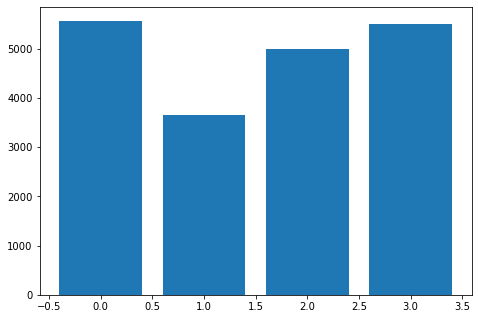

batch: 1
batch: 2
batch: 3
batch: 4
batch: 5
batch: 6
batch: 7
batch: 8
batch: 9
batch: 10


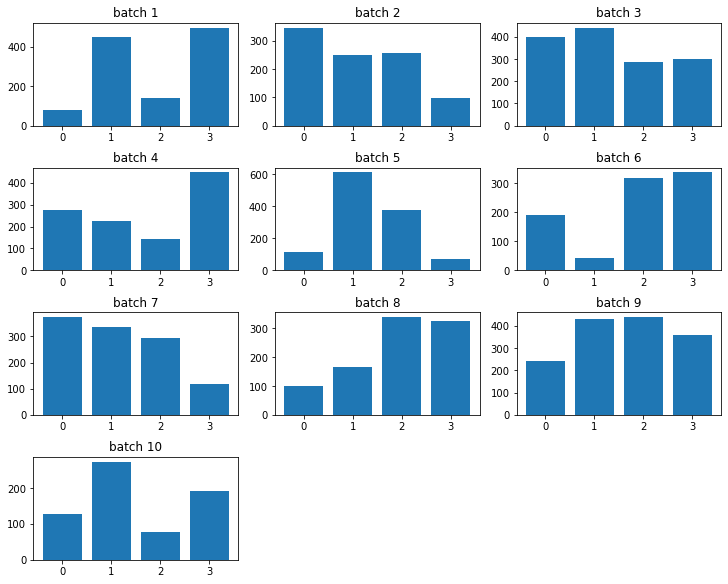

In [25]:
from random import sample
import numpy as np
import matplotlib.pyplot as plt
# ------ Configuration ------
# dataset = dgl.data.CoraGraphDataset()
# dataset = dgl.data.CiteseerGraphDataset()
dataset = dgl.data.PubmedGraphDataset()
partition_num = 4
khop = 2
roots_size = 20
num_samples = 10
## Start 

graph = dataset[0] 
graph = dgl.remove_self_loop(graph)
graph = dgl.add_self_loop(graph)
print(f"e_num={graph.num_edges()}; v_num={graph.num_nodes()}")
v2idx = dgl.metis_partition_assignment(graph, partition_num, balance_edges=True)
hist = np.histogram(v2idx, bins=np.arange(partition_num + 1) - 0.5)
print("partition histogram", hist)
fig = plt.figure()
ax1 = fig.add_axes([0,0,1,1])
x = np.arange(partition_num)
y = hist[0]
ax1.bar(x,y)
plt.show()

v_num = graph.num_nodes()
v_list = [i for i in range(0, v_num)]

total_e_num = 0
total_c_num = 0
total_k_num = 0
total_workload = np.zeros((partition_num, ), dtype=int) # local aggregation workload


def trim_axs(axs, N):
    """
    Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
    """
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]
rows = 4
cols = num_samples // rows + 1
axs = plt.figure(figsize=(10,8), constrained_layout=True).subplots(rows, cols)
axs = trim_axs(axs, num_samples)

for i in range(1, num_samples+1):
    print(f"batch: {i}")
    roots = sample(v_list, roots_size)
    roots = [int(x) for x in roots]        
    e_num, c_num, k_num, batch_workload = simulate(khop=khop, roots=roots, graph=graph, v2idx=v2idx)
    total_e_num += e_num
    total_c_num += c_num
    total_k_num += k_num
    np.sum([total_workload, batch_workload], axis=0, out=total_workload)
    ax = axs[i-1]
    ax.set_title(f'batch {i}')
    x = np.arange(partition_num)
    ax.bar(x, batch_workload)

    
# print("workload distribution: ", np.divide(total_workload, np.sum(total_workload)))
# print(f"e_num={total_e_num}; c_num={total_c_num}; k_num={total_k_num}")
# if total_k_num > 0:
#     print(f"cache miss:  {total_c_num * 100.0 / total_e_num }%")
#     print(f"memory copy: {total_k_num * 100.0 / total_e_num }%")